# Intro

In this example, we will look at how you can use braingraphgeo to load in brain graphs, visualize them as connectivity matrices. We will also compare brain graphs from neural tracer  data and diffusion MRI tractography in terms of their weight distributions and [spearman correlations](https://en.wikipedia.org/wiki/Spearman's_rank_correlation_coefficient) between connectivity weights within major brain divisions

We start by importing some basic packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

np.seterr(divide='ignore');  # catch divide-by-zero warnings

## Loading data

braingraphgeo assumes brain graph data is stored in .csv files as connectivity matrices with node labels in the index and columns. We can use a utility function to load the tracer data here:

In [2]:
from braingraphgeo.utils import load_connectivity_matrix

tracer = load_connectivity_matrix('../data/tracer.csv')
tracer.head()

,FRP-I,MOp-I,MOs-I,SSp-n-I,SSp-bfd-I,SSp-ll-I,SSp-m-I,SSp-ul-I,SSp-tr-I,SSp-un-I,...,NOD-C,SIM-C,AN-C,PRM-C,COPY-C,PFL-C,FL-C,FN-C,IP-C,DN-C
FRP-I,0.000000,0.000652,0.002070,0.000450,0.000079,0.000019,0.000363,0.000169,0.000022,0.000254,...,2.601909e-07,8.715997e-07,9.266404e-07,5.480758e-07,6.565844e-07,1.202899e-06,1.055080e-06,9.430097e-08,2.879349e-08,3.563321e-07
MOp-I,0.000652,0.000000,0.001087,0.000720,0.000259,0.000832,0.001586,0.001225,0.000373,0.000860,...,3.850061e-07,7.402989e-07,7.013316e-07,7.231367e-07,4.504190e-07,8.125623e-07,1.442125e-06,1.993170e-07,6.664356e-07,3.635951e-07
MOs-I,0.002070,0.001087,0.000000,0.000799,0.000440,0.000320,0.000737,0.000497,0.000333,0.000607,...,2.221067e-07,8.109482e-07,6.995438e-07,4.591654e-07,3.447931e-07,1.000104e-06,1.250267e-06,3.490379e-07,4.640053e-07,5.316008e-07
SSp-n-I,0.000450,0.000720,0.000799,0.000000,0.000783,0.000083,0.001819,0.001017,0.000046,0.002554,...,1.722713e-07,8.356792e-08,1.615161e-07,1.380850e-07,3.043041e-07,9.640356e-07,6.177427e-07,1.207246e-07,6.743341e-08,1.120574e-07
SSp-bfd-I,0.000079,0.000259,0.000440,0.000783,0.000000,0.000535,0.000087,0.000714,0.001240,0.001552,...,4.175421e-07,2.236231e-07,7.970255e-07,5.749913e-07,1.124917e-06,4.662613e-06,1.749775e-06,3.190695e-07,3.541172e-07,1.899686e-07


These values represent normalized connection density weights calculated with the connectivity model published [here](https://direct.mit.edu/netn/article/3/1/217/2194/High-resolution-data-driven-model-of-the-mouse)

The acronyms in the index and columns correspond to anatomical structures defined in the Allen Reference Atlas. 

This data uses a parcellation of 286 gray-matter structures per hemisphere:

In [3]:
tracer.shape

(572, 572)

We have also forced these values to be "undirected", meaning the weight from node i to node j is the same as from node j to node i. This was done in order to match the naturally unweighted graphs from tractography, which are derived from a symmetric diffusion measurement.

In other words:

In [4]:
np.sum(tracer.values - tracer.values.T)

0.0

## Visualize the connectivity matrix

We can visualize the connectivity matrix using matplotlib:

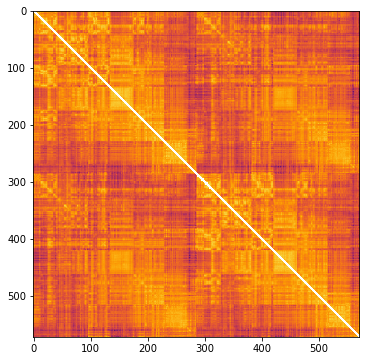

In [5]:
fig, ax = plt.subplots(figsize=(12,6))

plt.imshow(np.log10(tracer.values),cmap='inferno');

We note that the matrix also shows hemispheric symmetry. This was enforced since the tracer experiments underlying the Knox model were based on injects to a single hemisphere. 

braingraphgeo includes a visualization tool for displaying single-hemisphere connectivity graphs:

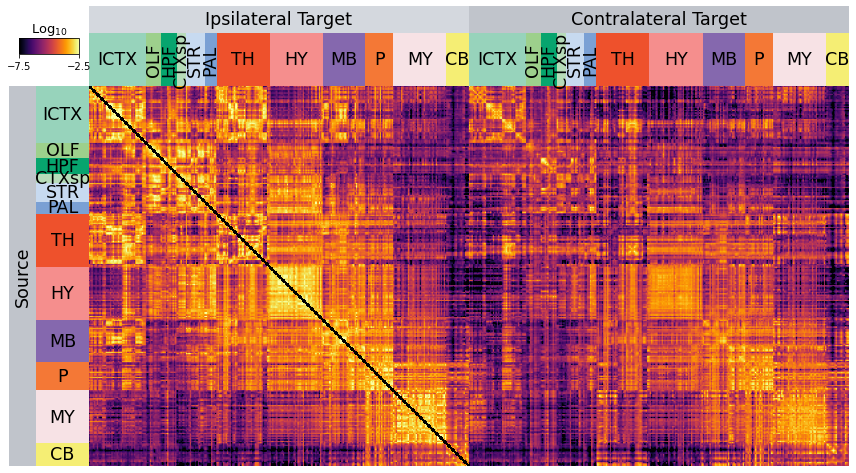

In [6]:
from braingraphgeo.vis import connectivity_matrix

# Load just a single hemisphere 
tracer_hemi_df = load_connectivity_matrix('../data/tracer.csv',
                                  return_both_hemispheres=False)
tracer = tracer_hemi_df.values

# Load parcellation data
parcellation = pd.read_csv('../data/parcellation.csv')

# Generate nice connectivity matrix visualization
fig, ax = connectivity_matrix(np.log10(tracer),parcellation,vmin=-7.5,vmax=-2.5)

# Comparing tracer and tractography graphs

## Load and visualize data

First, let's load all tractography data and create average graphs for each method

In [7]:
dense_tract_mats = []
endpoint_tract_mats = []
for i in range(1,6):
    dense_mat = load_connectivity_matrix(f'../data/tract_dense_n{i}.csv',return_both_hemispheres=False).values
    dense_tract_mats.append(dense_mat)
    
    endpoint_mat = load_connectivity_matrix(f'../data/tract_endpoint_n{i}.csv',return_both_hemispheres=False).values
    endpoint_tract_mats.append(endpoint_mat)

dense_tract = np.mean(dense_tract_mats,0)
endpoint_tract = np.mean(endpoint_tract_mats,0)

Let's visualize the dense graph:

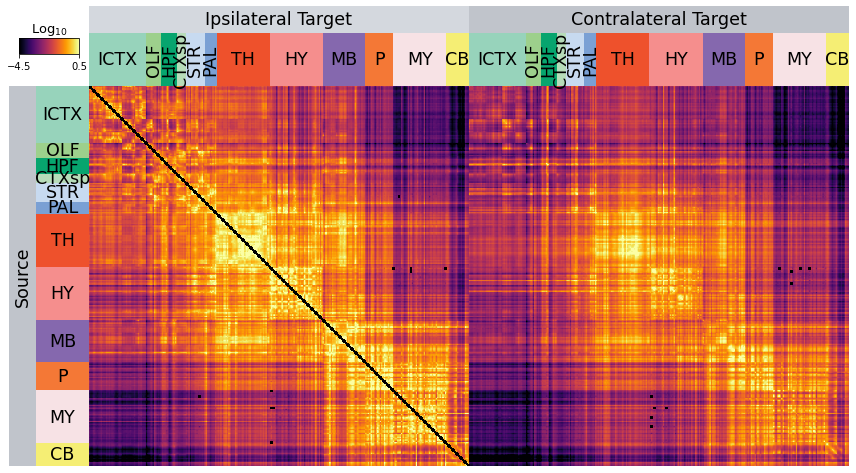

In [8]:
fig, ax = connectivity_matrix(np.log10(dense_tract), parcellation, vmin=-4.5,vmax=0.5)

And the endpoint graph:

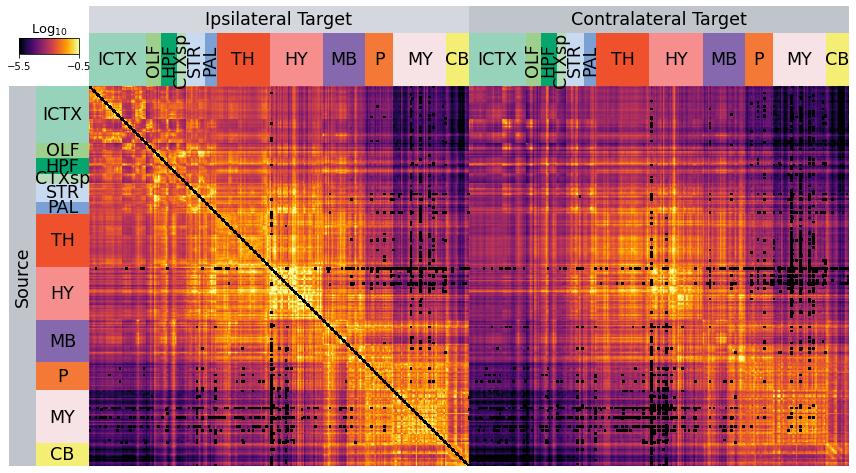

In [9]:
fig, ax = connectivity_matrix(np.log10(endpoint_tract), parcellation, vmin=-5.5,vmax=-0.5)

## Compare weight distributions

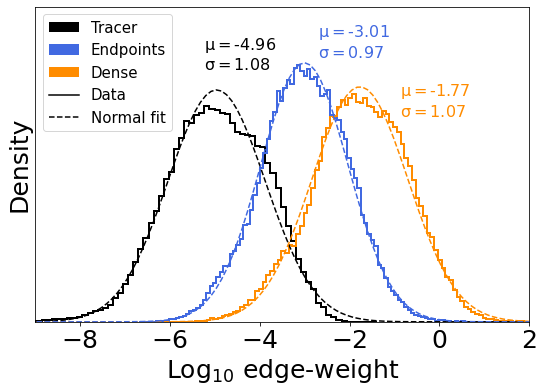

In [10]:
import matplotlib
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

matplotlib.rc('font', **{'size': 25})

def clean_dist(a):
    a = a[a != 0]
    return np.log10(a)

def gauss(x, mu, sig):
    return 1 / np.sqrt(2*np.pi*sig**2) * np.exp(-(x - mu)**2 / (2*sig**2))

txtfs = 16
legfs = 15

nbins = 100
params = {
    'bins': nbins,
    'density': True,
    'histtype': 'step',
    'lw': 2
}
colors = {'endpoint': 'royalblue','dense': 'darkorange'}
shift = {'endpoint': [0.3, 1.03],'dense': [0.9, 0.9]}
x = np.linspace(-9.5, 2, 100)

fig, ax = plt.subplots(figsize=(8, 6))

# Plot tracer
tr = clean_dist(tracer)
h, _, _ = ax.hist(tr, color='k', **params)
ax.plot(x, gauss(x, tr.mean(), tr.std()), 'k--')
ax.text(
    -5.25, 0.4,
    fr'$\rm \mu=${tr.mean():.2f}' + '\n' +
    rf'$\rm \sigma={tr.std():.2f}$',
    fontsize=txtfs
)

# Iterate over dense and endpoints
for conn, tract_df in zip(['dense','endpoint'],[dense_tract, endpoint_tract]):
    tr = clean_dist(tract_df)
    h, _, _ = ax.hist(tr, color=colors[conn], ls='-', **params)
    ax.plot(x, gauss(x, tr.mean(), tr.std()), ls='--', color=colors[conn])
    ax.text(tr.mean() + shift[f'{conn}'][0], np.max(h)*shift[f'{conn}'][1],
                fr'$\rm \mu=${tr.mean():.2f}' + '\n' + rf'$\rm \sigma={tr.std():.2f}$',
                fontsize=txtfs,
                color=colors[conn])
    
# Legend, labels, etc.
handles = [Patch(facecolor='k', label='Tracer'),
           Patch(facecolor=colors['endpoint'],label='Endpoints'),
           Patch(facecolor=colors['dense'],label='Dense'),
           Line2D([0], [0], color='k',ls='-', label='Data'),
           Line2D([0], [0], color='k', ls='--', label='Normal fit')]
ax.legend(handles=handles,fontsize=legfs,loc='upper left')
ax.set_xlim([-9, 2])
ax.set_ylim([0, 0.5])
ax.set_xlabel(r'Log$_{10}$ edge-weight')
ax.set_ylabel('Density')
ax.set_yticks([])
fig.tight_layout()

We see that the three brain graph construction methods have similarly lognormal weight distributions, with differences in means explained by the difference in the interpretation of weight units.

## Evaluate spearman correlations between major brain divisions

braingraphgeo also provides utilities to construct correlation matrices between two brain graphs, giving the value of the Spearman rank correlation coefficient between edge-weights between 12 major brain divisions identified by the Allen Reference Atlas

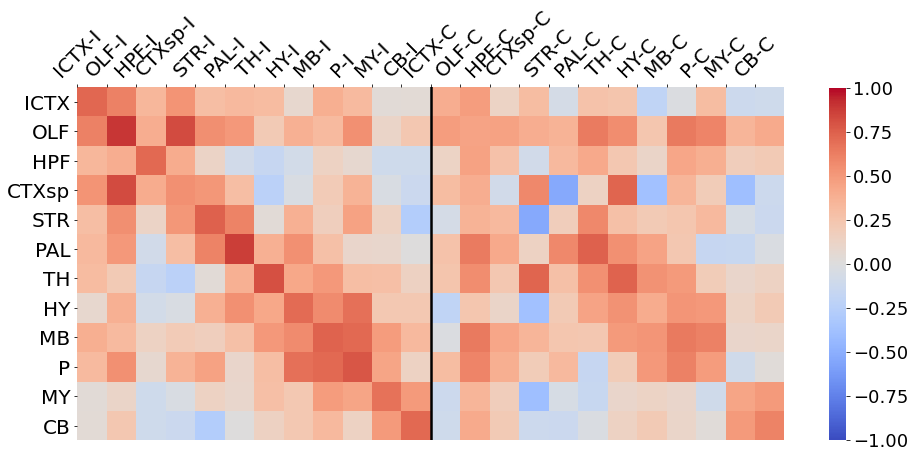

In [11]:
from braingraphgeo.utils import build_spearman_correlation_matrix
from braingraphgeo.vis import plot_spearman_correlation_matrix

# Dense
tracer_dense_corr = build_spearman_correlation_matrix(tracer,dense_tract,parcellation)
fig, ax = plot_spearman_correlation_matrix(tracer_dense_corr)

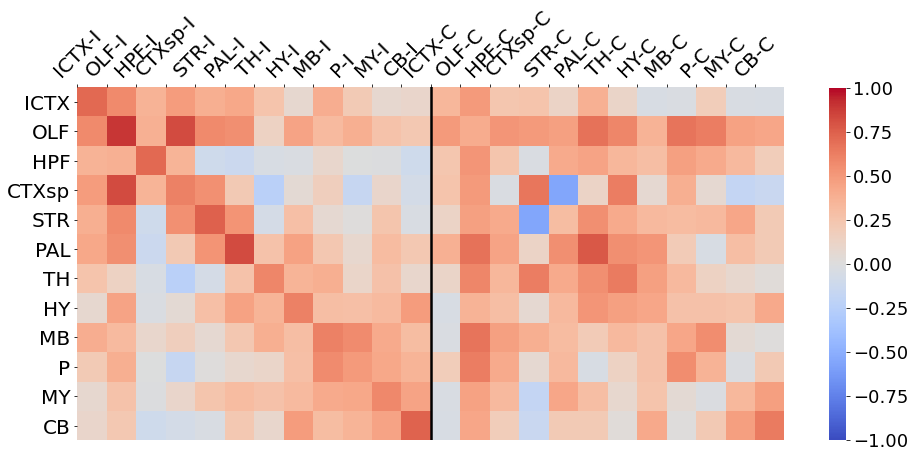

In [12]:
# Endpoint
tracer_endpoint_corr = build_spearman_correlation_matrix(tracer,endpoint_tract,parcellation)
fig, ax = plot_spearman_correlation_matrix(tracer_endpoint_corr)